In [1]:
import os
import requests
import pandas as pd
from astropy.io import fits
from io import StringIO
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import gamma
from scipy.optimize import minimize
from scipy.interpolate import RectBivariateSpline
import emcee
import corner
import scipy.io as sio
from ipywidgets import FloatProgress
from IPython.display import display
import time

In [2]:
stellarCatalog = "../stellarCatalogs/dr25_stellar_supp_gaia_clean_GKM.txt"
pcCatalog = "koiCatalogs/dr25_GKM_PCs.csv"

period_rng = (10, 400)
n_period = 100
rp_rng = (4, 15)
n_rp = 100

# for quick tests
nWalkers = 6
nBurnin = 200
nMcmc = 1000
# for production runs
#nWalkers = 100
#nBurnin = 1000
#nMcmc = 2000


model = "dualPowerLaw"
# which Radii lets you try with planet radii corrected for Gaia radii (whichRadii = "corrected")
# or with original KOI table planet radii (whichRadii = "kic")
whichRadii = "corrected"

In [3]:
def rateModel(x, y, xRange, yRange, theta, model):
    if model == "dualPowerLaw":
        f0, alpha, beta = theta
        ap1 = alpha+1;
        bp1 = beta+1;
        r = f0*(ap1*(x**alpha)/(xRange[1]**ap1-xRange[0]**ap1))*(bp1*(y**beta)/(yRange[1]**bp1-yRange[0]**bp1))
    else:
        raise ValueError('Bad model name');      
    return r

def getModelLabels(model):
    if model == "dualPowerLaw":
        return [r"$F_0$", r"$\beta$", r"$\alpha$"]
    else:
        raise ValueError('Bad model name');

def initRateModel(model):
    if model == "dualPowerLaw":
        f0 = 0.75
        alpha = -0.53218
        beta = -0.5
        theta = [f0, alpha, beta]
    else:
        raise ValueError('Bad model name');
  
    return theta

def lnPoisprior(theta, model):
    if model == "dualPowerLaw":
        if 0.0 <= theta[0] <= 5 \
        and -5.0 <= theta[1] <= 5.0 \
        and -5.0 <= theta[2] <= 5.0:
            return 1.0
    else:
        raise ValueError('Bad model name');
        
    # print(theta)
    return -np.inf

In [4]:
def medianAndErrorbars(data):
    if data.ndim > 1:
        dataResult = map(lambda v: (v[1], v[2]-v[1], v[1]-v[0]),
                             zip(*np.percentile(data, [16, 50, 84],
                                                axis=0)))
        dataResult = list(dataResult)
        return dataResult
    else:
        v = np.percentile(data, [16, 50, 84])
        return [v[1], v[2]-v[1], v[1]-v[0]]

def printMedianAndErrorbars(data):
    e = medianAndErrorbars(data)
    if data.ndim > 1:
        print("printMedianAndErrorbars only works for 1D arrays")
    else:
        return "{:.3f}".format(e[0]) +"^{+" + "{:.3f}".format(e[1]) + "}_{-" + "{:.3f}".format(e[2]) + "}"

In [5]:
from scipy.integrate import romb

def integrate2DGrid(g, dx, dy):
    if g.shape[0]%2 == 0 or g.shape[1]%2 == 0:
        raise ValueError('integrate2DGrid requires a grid with odd number of points on a side');
    return romb(romb(g, dx), dy)

def integrateRateModel(periodRange, rpRange, theta, model):
    nPts = 2**5+1 # must be 2**n + 1
    pGrid, rGrid = np.meshgrid(np.logspace(np.log10(periodRange[0]), np.log10(periodRange[1]), nPts), 
                                       np.logspace(np.log10(rpRange[0]), np.log10(rpRange[1]), nPts), indexing="ij")
    dp = (pGrid[1,0]-pGrid[0,0])
    dr = (rGrid[0,1]-rGrid[0,0])
    
    if theta.ndim == 1:
        y = rateModel(pGrid, rGrid, period_rng, rp_rng, theta, model)
        return integrate2DGrid(y, dp, dr)
    else: # assume first dimension is array of thetas
        ret = np.zeros(theta.shape[0])
        if len(ret) > 100:
            f = FloatProgress(min=0, max=len(ret))
            display(f)

        for i in range(len(ret)):
            y = rateModel(pGrid, rGrid, period_rng, rp_rng, theta[i,:], model)
            ret[i] = integrate2DGrid(y, dp, dr)
            if len(ret) > 100:
                f.value += 1
        return ret

def integratePopTimesComp(periodRange, rpRange, theta, model, compGrid):
    nP = compGrid.shape[0]
    nR = compGrid.shape[1]

    pGrid, rGrid = np.meshgrid(np.logspace(np.log10(periodRange[0]), np.log10(periodRange[1]), nP), 
                                       np.logspace(np.log10(rpRange[0]), np.log10(rpRange[1]), nR), 
                                       indexing="ij")
    dp = (pGrid[1,0]-pGrid[0,0])
    dr = (rGrid[0,1]-rGrid[0,0])
    y = rateModel(pGrid, rGrid, period_rng, rp_rng, theta, model)*compGrid
    return integrate2DGrid(y, dp, dr)

In [6]:
# population inference functions
def lnlike(theta):
    pop = rateModel(period_grid, rp_grid, period_rng, rp_rng, theta, model) * summedCompleteness
    pop = 0.5 * (pop[:-1, :-1] + pop[1:, 1:])
    norm = np.sum(pop * vol)
    ll = np.sum(np.log(rateModel(koi_periods, koi_rps, period_rng, rp_rng, theta, model))) - norm
    return ll if np.isfinite(ll) else -np.inf

# The ln-probability function is just propotional to the ln-likelihood
# since we're assuming uniform priors.
def lnprob(theta):
    lp = lnPoisprior(theta, model)
    if not np.isfinite(lp):
        return -np.inf

    return lnlike(theta)

# The negative ln-likelihood is useful for optimization.
# Optimizers want to *minimize* your function.
def nll(theta):
    ll = lnlike(theta)
    return -ll if np.isfinite(ll) else 1e15

In [7]:
def getRadii(catalog):
    if whichRadii == "corrected":
        return catalog.corrected_prad
    elif whichRadii == "kic":
        return catalog.koi_prad
    else:
        raise ValueError('Bad whichRadii string')

In [8]:
stellarTargets = pd.read_csv(stellarCatalog)
base_kois = pd.read_csv(pcCatalog)
m = (period_rng[0] <= base_kois.koi_period) & (base_kois.koi_period <= period_rng[1])
thisRadii = getRadii(base_kois)
m &= np.isfinite(thisRadii) & (rp_rng[0] <= thisRadii) & (thisRadii <= rp_rng[1])
    
kois = pd.DataFrame(base_kois[m])
allKois = kois

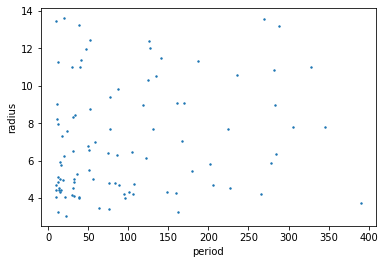

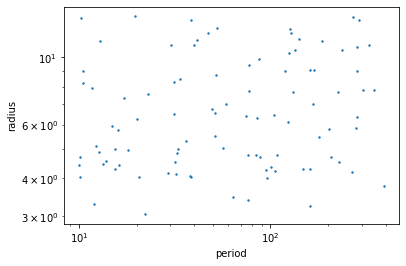

In [9]:
plt.figure()
plt.scatter(kois.koi_period, kois.koi_prad, s=2)
#plt.ylim(0, 5)
plt.xlabel('period')
plt.ylabel('radius')

plt.figure()
plt.scatter(kois.koi_period, kois.koi_prad, s=2)
plt.yscale('log')
plt.xscale('log')
plt.xlabel('period')
plt.ylabel('radius')
plt.show()

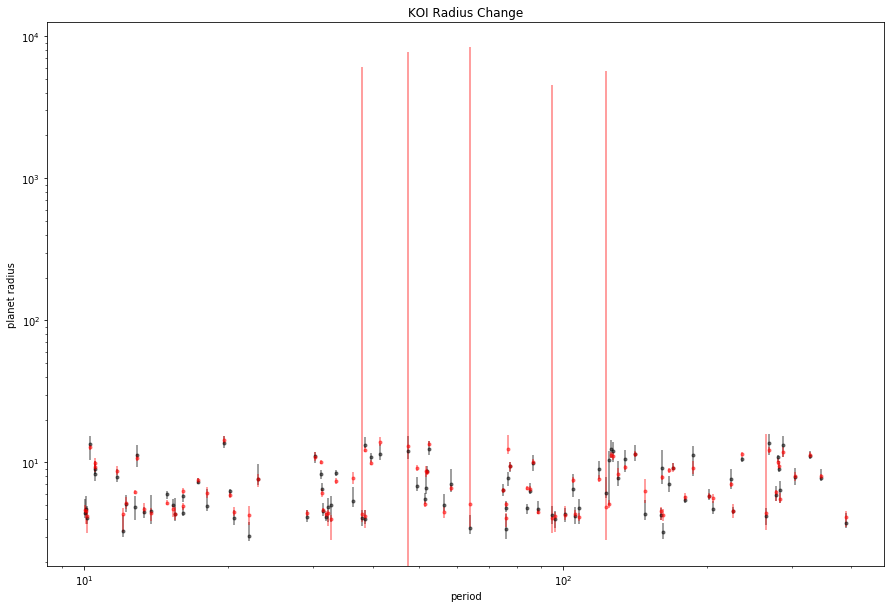

In [10]:
fig, ax = plt.subplots(figsize=(15,10))
ax.errorbar(kois.koi_period, kois.koi_prad, 
            yerr = [-kois.koi_prad_err2, kois.koi_prad_err1],
            fmt="k.", alpha = 0.5)
ax.errorbar(kois.koi_period, kois.corrected_prad, 
            yerr = [-kois.corrected_prad_err2, kois.corrected_prad_err1],
            fmt="r.", alpha = 0.5)

plt.xlabel("period")
plt.ylabel("planet radius")
plt.title("KOI Radius Change")
plt.yscale('log')
plt.xscale('log')
plt.show()

In [11]:
period = np.logspace(np.log10(period_rng[0]), np.log10(period_rng[1]), n_period)
rp = np.logspace(np.log10(rp_rng[0]), np.log10(rp_rng[1]), n_rp)
period_grid, rp_grid = np.meshgrid(period, rp, indexing="ij")
periodShape = period_grid.shape

In [12]:
inputgrid = "../completenessContours/out_sc0_GKM_baseline.fits.gz"

hdulist = fits.open(inputgrid)
cumulative_array = hdulist[0].data
kiclist = np.asarray(hdulist[1].data, dtype=np.int32)
probdet = np.transpose(cumulative_array[0])
probtot = np.transpose(cumulative_array[1])
prihdr = hdulist[0].header
min_comp_period = prihdr["MINPER"]
max_comp_period = prihdr["MAXPER"]
n_comp_period = prihdr["NPER"]
min_comp_rp = prihdr["MINRP"]
max_comp_rp = prihdr["MAXRP"]
n_comp_rp = prihdr["NRP"]
# print "KIC list length" + '{:6d}'.format(kiclist.size)
print(hdulist[0].header,)

period_want = np.logspace(np.log10(min_comp_period), np.log10(max_comp_period), n_comp_period)
rp_want = np.logspace(np.log10(min_comp_rp), np.log10(max_comp_rp), n_comp_rp)
period_want2d, rp_want2d = np.meshgrid(period_want, rp_want)

numCompVeInterp = RectBivariateSpline(period_want, rp_want, probtot)
numProbDetInterp = RectBivariateSpline(period_want, rp_want, probdet)

SIMPLE  =                    T / conforms to FITS standard                      BITPIX  =                  -64 / array data type                                NAXIS   =                    3 / number of array dimensions                     NAXIS1  =                 2000                                                  NAXIS2  =                 3000                                                  NAXIS3  =                    2                                                  EXTEND  =                    T                                                  MINPER  =                 10.0                                                  MAXPER  =                400.0                                                  NPER    =                 2000                                                  MINRP   =                  4.0                                                  MAXRP   =                 15.0                                                  NRP     =                 3000          

In [51]:
hdulist[0].header

SIMPLE  =                    T / conforms to FITS standard                      
BITPIX  =                  -64 / array data type                                
NAXIS   =                    3 / number of array dimensions                     
NAXIS1  =                 2000                                                  
NAXIS2  =                 3000                                                  
NAXIS3  =                    2                                                  
EXTEND  =                    T                                                  
MINPER  =                 10.0                                                  
MAXPER  =                400.0                                                  
NPER    =                 2000                                                  
MINRP   =                  4.0                                                  
MAXRP   =                 15.0                                                  
NRP     =                 30

In [52]:
hdulist[1].header

XTENSION= 'BINTABLE'           / binary table extension                         
BITPIX  =                    8 / array data type                                
NAXIS   =                    2 / number of array dimensions                     
NAXIS1  =                    4 / length of dimension 1                          
NAXIS2  =                54717 / length of dimension 2                          
PCOUNT  =                    0 / number of group parameters                     
GCOUNT  =                    1 / number of groups                               
TFIELDS =                    1 / number of table fields                         
TTYPE1  = 'kiclist '                                                            
TFORM1  = 'J       '                                                            

In [13]:
summedCompleteness = numCompVeInterp(period, rp)
summedProbDet = numProbDetInterp(period, rp)

In [14]:
print(summedCompleteness.shape)
print(summedProbDet.shape)

(100, 100)
(100, 100)


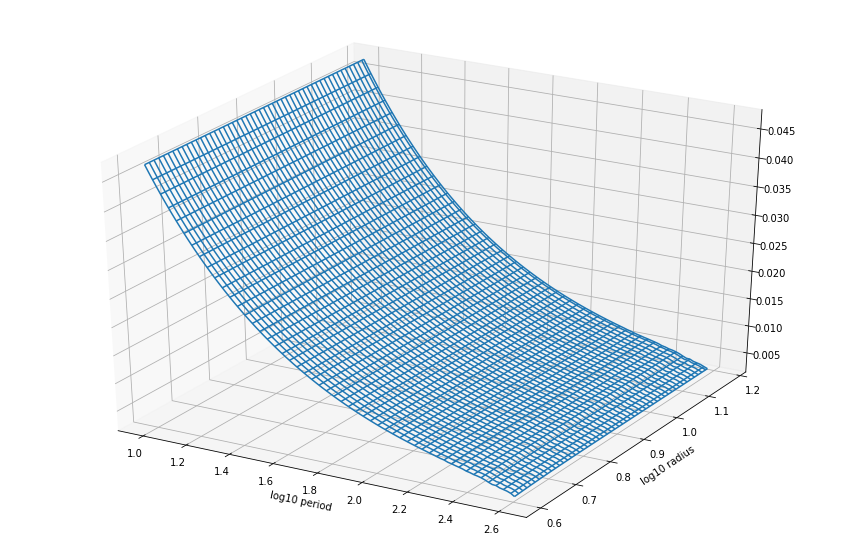

In [53]:
from mpl_toolkits.mplot3d import axes3d

fig = plt.figure(figsize=(15,10))
ax = fig.add_subplot(111, projection='3d')

logp = np.log10(period_grid)
logr = np.log10(rp_grid)

ax.plot_wireframe(logp, logr, summedCompleteness / kiclist.size, rstride=2, cstride=2)
#ax.plot_surface(period_grid, rp_grid, summedProbDet)
#plt.xlim(0,100)  
#plt.ylim(0,1)  
ax.set_xlabel('log10 period')
ax.set_ylabel('log10 radius')
plt.show()

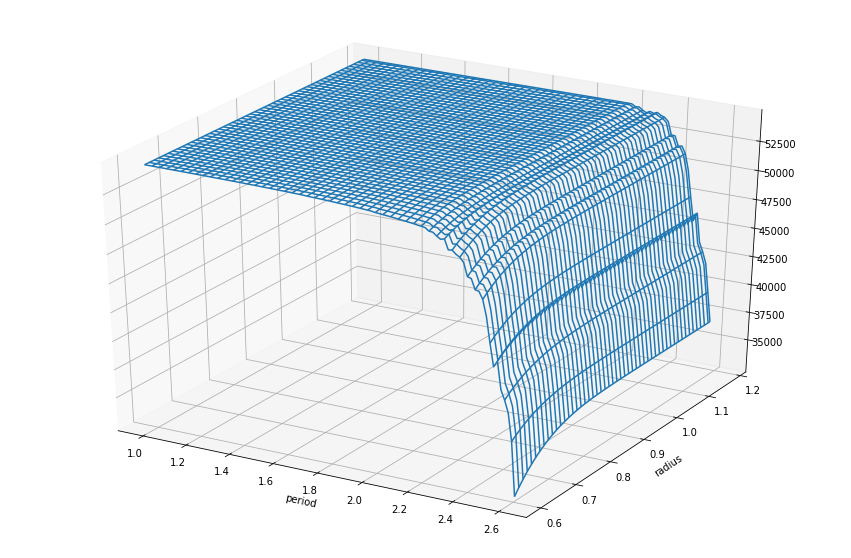

In [54]:
from mpl_toolkits.mplot3d import axes3d
fig = plt.figure(figsize=(15,10))
ax = fig.add_subplot(111, projection='3d')

#ax.plot_wireframe(period_grid, rp_grid, summedCompleteness / kiclist.size, rstride=2, cstride=2)
ax.plot_wireframe(np.log10(period_grid), np.log10(rp_grid), summedProbDet)
ax.set_xlabel('period')
ax.set_ylabel('radius')
plt.show()

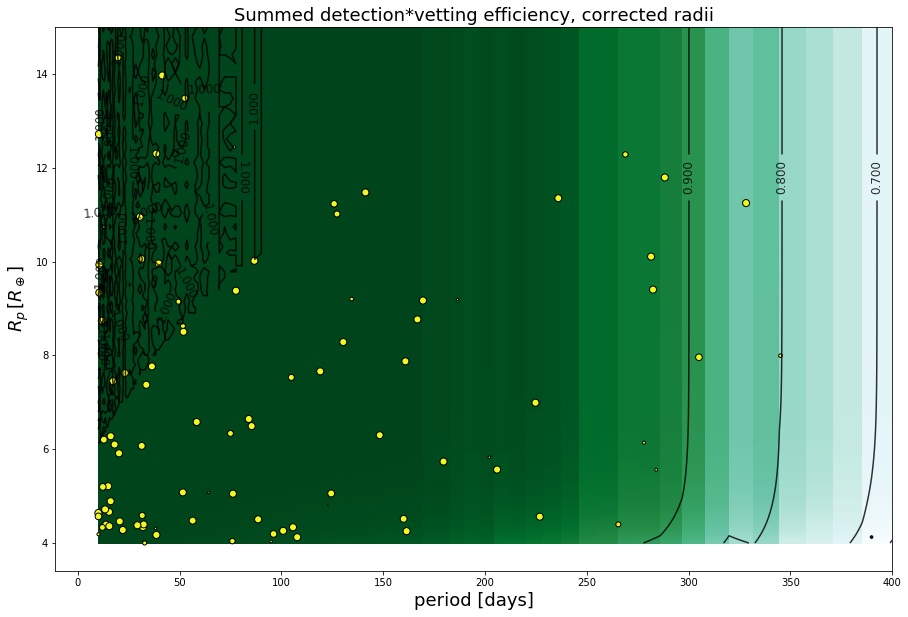

In [17]:
# contourLevels = np.arange(1e-2, 1, 5e-2)
contourLevels = [0.01, 0.05, 0.1, 0.25, 0.5, 0.6, 0.7, 0.8, 0.9, 1.0]

#fig, ax = plt.subplots(figsize=(15,10))
plt.figure(figsize=(15,10))
plt.pcolor(period_grid, rp_grid, summedProbDet, cmap="BuGn")
c = plt.contour(period_grid, rp_grid, summedProbDet / kiclist.size, contourLevels,
               colors="k", alpha=0.8)
scf = plt.scatter(kois.koi_period, getRadii(kois), cmap="plasma", 
               c=kois.reliability, edgecolors='k', s=50*kois.totalReliability, alpha = 1.0)

#cbh = plt.colorbar(scf)
#cbh.ax.set_ylabel("Instrumental FP Reliability")

#c = plt.contour(period_grid, rp_grid, numCompVe / kiclist.size, colors="k", alpha=0.8)
plt.clabel(c, fontsize=12, inline=1, fmt="%.3f")
plt.title("Summed detection*vetting efficiency, " + whichRadii + " radii", fontsize = 18)
plt.xlabel("period [days]", fontsize = 18)
plt.ylabel("$R_p \, [R_\oplus]$", fontsize = 18)
#plt.ylim(0, 10)
#plt.xlim(0,500)
#plt.axhline(y=0.7)
#plt.savefig("summedCompleteness.pdf",bbox_inches='tight')
plt.show()

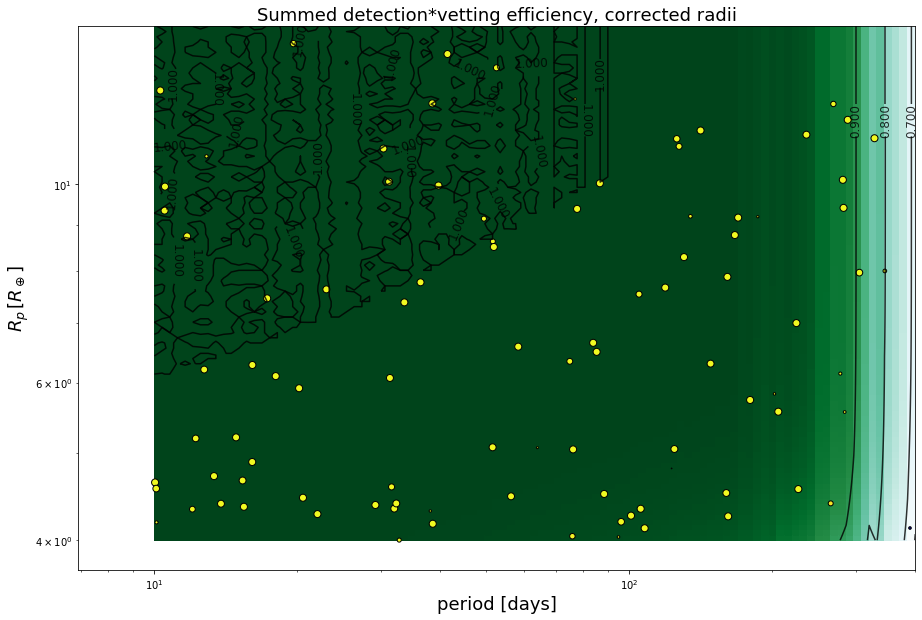

In [18]:
plt.figure(figsize=(15,10))

plt.pcolor(period_grid, rp_grid, summedProbDet, cmap="BuGn")
c = plt.contour(period_grid, rp_grid, summedProbDet / kiclist.size, contourLevels,
               colors="k", alpha=0.8)
scf = plt.scatter(kois.koi_period, getRadii(kois), cmap="plasma", 
               c=kois.reliability, edgecolors='k', s=50*kois.totalReliability, alpha = 1.0)

plt.clabel(c, fontsize=12, inline=1, fmt="%.3f")
plt.title("Summed detection*vetting efficiency, " + whichRadii + " radii", fontsize = 18)
plt.xlabel("period [days]", fontsize = 18)
plt.ylabel("$R_p \, [R_\oplus]$", fontsize = 18)
plt.yscale('log')
#plt.xlim(0.1, 500)
plt.xscale('log')
#plt.ylim(1, 10)
#plt.axhline(y=0.7)

plt.show()

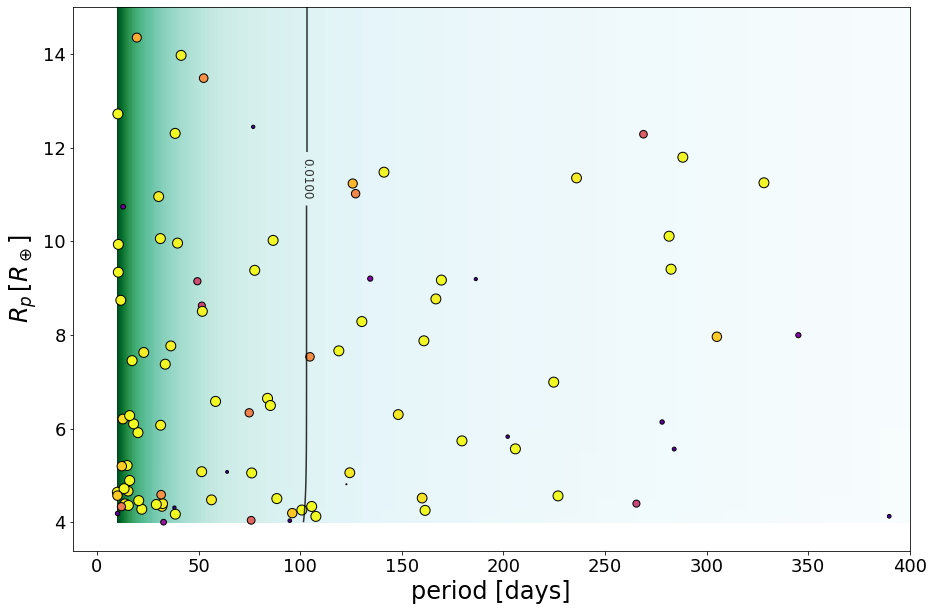

In [19]:
# contourLevels = np.arange(1e-2, 1, 5e-2)
#contourLevels = np.arange(1e-3, 1e-2, 1e-3)
#contourLevels = np.insert(contourLevels, 0, [1e-4, 5e-4])
contourLevels = [0.01, 0.05, 0.1, 0.25, 0.5, 0.6, 0.7, 0.8, 0.9, 1.0]
plt.figure(figsize=(15,10))

plt.pcolor(period_grid, rp_grid, summedCompleteness, cmap="BuGn")
c = plt.contour(period_grid, rp_grid, summedCompleteness / kiclist.size, contourLevels,
               colors="k", alpha=0.8)
ax.errorbar(kois.koi_period, getRadii(kois), 
           yerr = [-kois.corrected_prad_err2, kois.corrected_prad_err1],
         fmt="none", ecolor="k", alpha = 0.15, marker = None)
scf = plt.scatter(kois.koi_period, getRadii(kois), cmap="plasma", 
               c=kois.totalReliability, edgecolors='k', s=100*kois.totalReliability, alpha = 1.0)

#cbh = plt.colorbar(scf);
#cbh.ax.set_ylabel("Reliability", fontsize = 24);

#c = plt.contour(period_grid, rp_grid, numCompVe / kiclist.size,
#               colors="k", alpha=0.8)
#plt.ylim(1, 10)
#plt.xlim(50, 400)
plt.clabel(c, fontsize=12, inline=1, fmt="%.4f")
# plt.title("DR25 PC Average detection*vetting efficiency", fontsize = 18)
plt.tick_params(labelsize = 18)
plt.xlabel("period [days]", fontsize = 24)
plt.ylabel("$R_p \, [R_\oplus]$", fontsize = 24);
#plt.savefig("summedCompleteness.png",bbox_inches='tight')
#plt.xscale('log')
#plt.yscale('log')
plt.show()

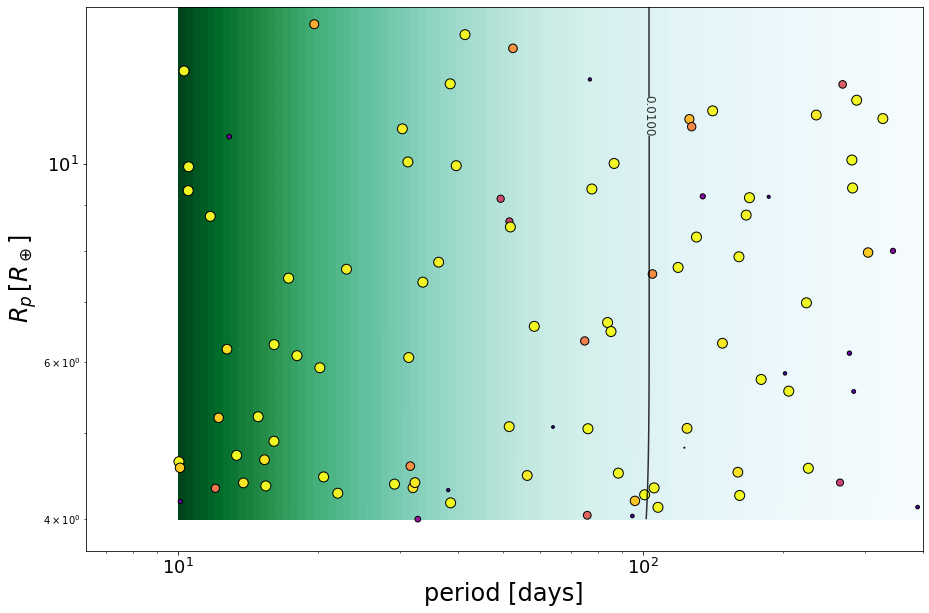

In [20]:
# contourLevels = np.arange(1e-2, 1, 5e-2)
#contourLevels = np.arange(1e-3, 1e-2, 1e-3)
#contourLevels = np.insert(contourLevels, 0, [1e-4, 5e-4])
#contourLevels = [0.001, 0.005, 0.01, 0.05, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1.0]

contourLevels = [0.01, 0.05, 0.1, 0.25, 0.5, 0.6, 0.7, 0.8, 0.9, 1.0]
plt.figure(figsize=(15,10))

plt.pcolor(period_grid, rp_grid, summedCompleteness, cmap="BuGn")
c = plt.contour(period_grid, rp_grid, summedCompleteness/ kiclist.size, contourLevels,
               colors="k", alpha=0.8)
ax.errorbar(kois.koi_period, getRadii(kois), 
           yerr = [-kois.corrected_prad_err2, kois.corrected_prad_err1],
         fmt="none", ecolor="k", alpha = 0.15, marker = None)
scf = plt.scatter(kois.koi_period, getRadii(kois), cmap="plasma", 
               c=kois.totalReliability, edgecolors='k', s=100*kois.totalReliability, alpha = 1.0)

#cbh = plt.colorbar(scf);
#cbh.ax.set_ylabel("Reliability", fontsize = 24);

#c = plt.contour(period_grid, rp_grid, numCompVe / kiclist.size,
#               colors="k", alpha=0.8)
#plt.ylim(1, 10)
#plt.xlim(0.1, 500)
plt.clabel(c, fontsize=12, inline=1, fmt="%.4f")
# plt.title("DR25 PC Average detection*vetting efficiency", fontsize = 18)
plt.tick_params(labelsize = 18)
plt.xlabel("period [days]", fontsize = 24)
plt.ylabel("$R_p \, [R_\oplus]$", fontsize = 24);
#plt.savefig("summedCompleteness.png",bbox_inches='tight')
plt.xscale('log')
plt.yscale('log')
plt.show()

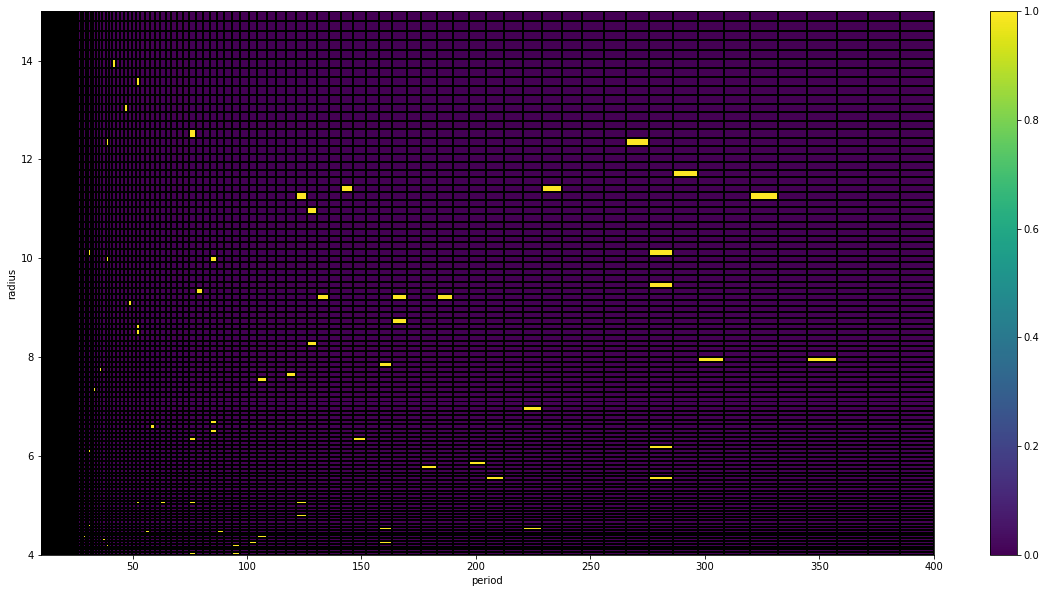

In [21]:
H, xedges, yedges = np.histogram2d(kois.koi_period, getRadii(kois), bins=(period, rp))

#X, Y = np.meshgrid(xedges, yedges)
fig, ax = plt.subplots(figsize=(20, 10))
#ax = fig.add_subplot(132)
im = ax.pcolormesh(period_grid, rp_grid, H, edgecolor='k', linewidth=1)
#plt.xlim(.1,500)
fig.colorbar(im)
plt.xlabel('period')
plt.ylabel('radius')
plt.show()

In [22]:
print(summedCompleteness.shape)

#counts, xedges, yedges = np.histogram2d(x, y, bins=30)
print(kiclist.size)
print((np.ravel(summedCompleteness)/kiclist.size).shape)

#print(H1)

(100, 100)
54717
(10000,)


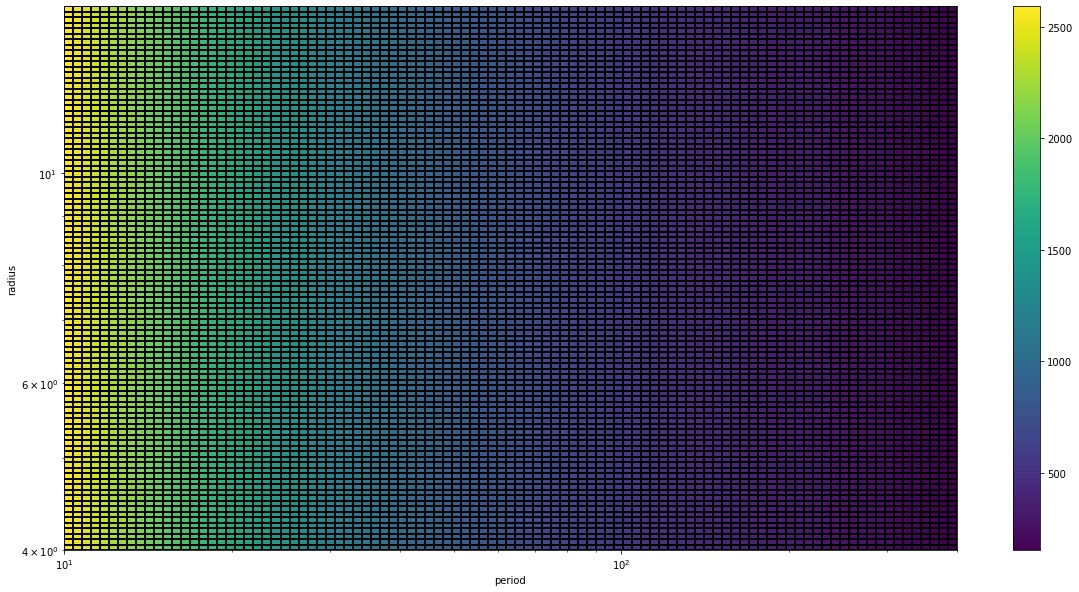

In [23]:
fig, ax = plt.subplots(figsize=(20, 10))
#ax = fig.add_subplot(132)
im = ax.pcolormesh(period_grid, rp_grid, summedCompleteness, edgecolor='k', linewidth=1)
#plt.xlim(.1,500)
plt.xscale('log')
plt.yscale('log')
plt.xlabel('period')
plt.ylabel('radius')
fig.colorbar(im)
plt.show()

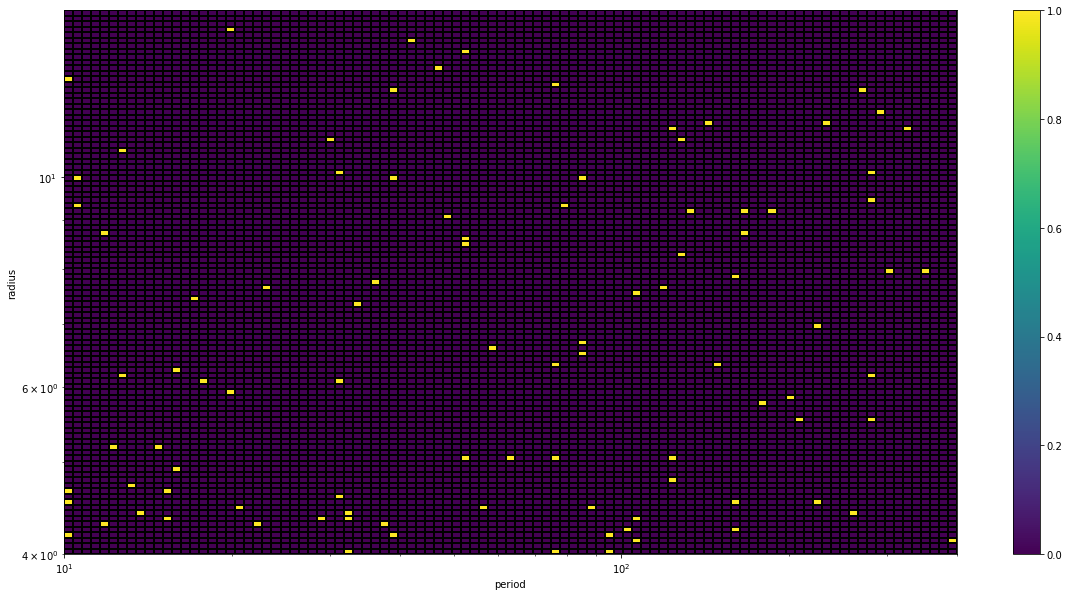

In [24]:
H1, xedges, yedges = np.histogram2d(kois.koi_period, getRadii(kois), bins=(period, rp))

#X, Y = np.meshgrid(xedges, yedges)
fig, ax = plt.subplots(figsize=(20, 10))
#ax = fig.add_subplot(132)
im = ax.pcolormesh(period_grid, rp_grid, H1, edgecolor='k', linewidth=1)
#plt.xlim(.1,500)
plt.xscale('log')
plt.yscale('log')
plt.xlabel('period')
plt.ylabel('radius')
fig.colorbar(im)
plt.show()

In [39]:
# population analysis functions modified from Daniel Foreman Mackey's https://dfm.io/posts/exopop/

# We'll reuse these functions to plot all of our results.
def make_plot(pop_comp, x0, x, y, ax, color):
    #print("in make_plot, pop_comp:")
    #print(pop_comp.shape)

    pop = 0.5 * (pop_comp[:, 1:] + pop_comp[:, :-1])
    #print("pop:")
    #print(pop.shape)
    pop = np.sum(pop * np.diff(y)[None, :, None], axis=1)
    a, b, c, d, e = np.percentile(pop * np.diff(x)[0], [2.5, 16, 50, 84, 97.5], axis=0)
    
    ax.fill_between(x0, a, e, color="k", alpha=0.1, edgecolor="none")
    ax.fill_between(x0, b, d, color="k", alpha=0.3, edgecolor="none")
    ax.plot(x0, c, color, lw=1)

def plot_results(samples):
    # Loop through the samples and compute the list of population models.
    samples = np.atleast_2d(samples)
    print("samples: %s" % samples)
    pop = np.empty((len(samples), period_grid.shape[0], period_grid.shape[1]))
    gamma_earth = np.empty((len(samples)))

    for i, p in enumerate(samples):
        print(i, p)
        pop[i] = rateModel(period_grid, rp_grid, period_rng, rp_rng, p, model)
        gamma_earth[i] = rateModel(365.25, 1.0, period_rng, rp_rng, p, model) * 365.
    
    fig, axes = plt.subplots(2, 2, figsize=(10, 8))
    fig.subplots_adjust(wspace=0.4, hspace=0.4)
    
    # Integrate over radius.
    dx = 0.25
    #x = np.arange(rp_rng[0], rp_rng[1] + dx, dx)
    x = np.logspace(np.log10(rp_rng[0]), np.log10(rp_rng[1]+1), 20)
    n, _ = np.histogram(koi_rps, x)
    
    fsize = 18
    # Plot the observed radius distribution.
    ax = axes[0, 0]
    make_plot(pop * summedCompleteness[None, :, :], rp, x, period, ax, color='r')
    ax.errorbar(0.5*(x[:-1]+x[1:]), n, yerr=np.sqrt(n), fmt=".k",
                capsize=0, ecolor="pink")
    #ax.set_xlim(rp_rng[0], rp_rng[1])
    ax.set_xlabel("$R_p\,[R_\oplus]$", fontsize = fsize)
    ax.set_ylabel("# of detected planets", fontsize = fsize)
    
    # Plot the true radius distribution.
    ax = axes[0, 1]
    make_plot(pop, rp, x, period, ax, color='b')
    #ax.set_xlim(rp_rng[0], rp_rng[1])
    #ax.set_ylim(0, 0.37)
    ax.set_xlabel("$R_p\,[R_\oplus]$", fontsize = fsize)
    ax.set_ylabel("$\mathrm{d}N / \mathrm{d}R$", fontsize = fsize)
    
    # Integrate over period.
    dx = 31.5
    #x = np.arange(period_rng[0], period_rng[1] + dx, dx)
    x = np.logspace(np.log10(period_rng[0]), np.log10(period_rng[1]+1), 10)
    #print(x)
    n, _ = np.histogram(koi_periods, x)
    
    # Plot the observed period distribution.
    ax = axes[1, 0]
    make_plot(np.swapaxes(pop * summedCompleteness[None, :, :], 1, 2), period, x, rp, ax, color='g')
    ax.errorbar(0.5*(x[:-1]+x[1:]), n, yerr=np.sqrt(n), fmt=".y",
                capsize=0, ecolor="c")
    #ax.set_xlim(period_rng[0], period_rng[1])
    #ax.set_ylim(0, 79)
    ax.set_xlabel("$P\,[\mathrm{days}]$", fontsize = fsize)
    ax.set_ylabel("# of detected planets", fontsize = fsize)
    
    # Plot the true period distribution.
    ax = axes[1, 1]
    make_plot(np.swapaxes(pop, 1, 2), period, x, rp, ax, color='m')
    #ax.set_xlim(period_rng[0], period_rng[1])
    #ax.set_ylim(0, 0.27)
    ax.set_xlabel("$P\,[\mathrm{days}]$", fontsize = fsize)
    ax.set_ylabel("$\mathrm{d}N / \mathrm{d}P$", fontsize = fsize)
    
    #fig, ax = plt.subplots()
    #make_plot(pop * summedCompleteness[None, :, :], rp, x, period, ax, color='r')
    #make_plot(pop, rp, x, period, ax, color='b')
    
    plt.show()
             
    return gamma_earth, fig

Compute a basic occurrence rate without reliability

/Users/anne/anaconda2/envs/python3/lib/python3.6/site-packages/ipykernel_launcher.py:6: RuntimeWarning: invalid value encountered in log
  


[ 0.20623535  0.         -2.06350241]
samples: [[ 0.20623535  0.         -2.06350241]]
0 [ 0.20623535  0.         -2.06350241]


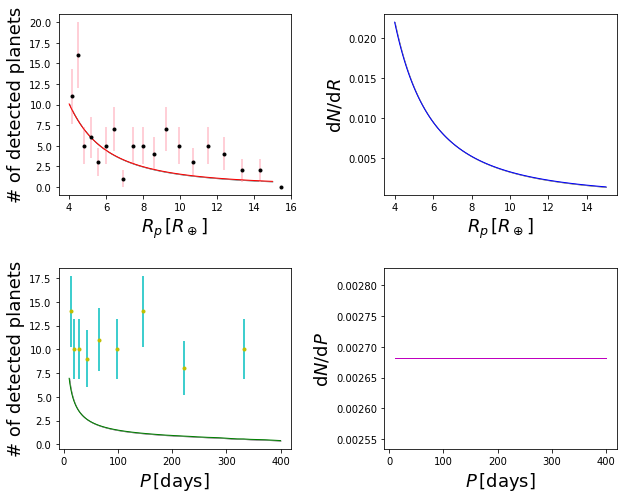

In [41]:
kois = allKois

if model == "dualPowerLaw":
    #bounds = [(0, 8), (-5, 5), (-5, 5)]
    bounds = [(-5, 8), (0, 0), (-5, 5)]
    
# The ln-likelihood function given at the top of this post.
koi_periods = np.array(kois.koi_period)
koi_rps = np.array(getRadii(kois))
# koi_rps = getRadii(kois)

vol = np.diff(period_grid, axis=0)[:, :-1] * np.diff(rp_grid, axis=1)[:-1, :]

theta_0 = initRateModel(model)
#theta_0 = [initRateModel(model)[0], initRateModel(model)[1], 5]
#print(theta_0)
#print(nll(theta_0))
r = minimize(nll, theta_0, method="L-BFGS-B", bounds=bounds)
print(r.x)
ge, fig = plot_results(r.x)
#[ 0.88074391 -0.50150404  0.11076642]

In [42]:

##################################################################

ndim, nwalkers = len(r.x), nWalkers
pos = [r.x + 1e-5 * np.random.randn(ndim) for i in range(nwalkers)]
sampler = emcee.EnsembleSampler(nwalkers, ndim, lnprob, threads=8)

# Burn in.
pos, _, _ = sampler.run_mcmc(pos, nBurnin)
sampler.reset()

# Production.
start_time = time.time()
pos, _, _ = sampler.run_mcmc(pos, nMcmc)
print("--- %s seconds ---" % (time.time() - start_time))

samples_noreliability = sampler.flatchain   

--- 3.790055274963379 seconds ---


samples: [[ 0.1578776  -0.4359411  -2.15494164]
 [ 0.13360199 -0.43818672 -2.19980771]
 [ 0.16085817 -0.34349149 -2.07490471]
 ...
 [ 0.16572861 -0.43590004 -2.25074081]
 [ 0.17270853 -0.24282109 -2.30348553]
 [ 0.22199835 -0.28613195 -2.16534913]]
0 [ 0.1578776  -0.4359411  -2.15494164]
1 [ 0.13360199 -0.43818672 -2.19980771]
2 [ 0.16085817 -0.34349149 -2.07490471]
3 [ 0.1840033  -0.31643909 -2.04050212]
4 [ 0.13828799 -0.40941868 -2.28398464]
5 [ 0.16890124 -0.26401765 -1.42621488]
6 [ 0.16164835 -0.45699088 -2.16527462]
7 [ 0.13688616 -0.42785035 -2.20306111]
8 [ 0.14881306 -0.38533941 -2.1301021 ]
9 [ 0.20207021 -0.28106521 -1.99450089]
10 [ 0.15087921 -0.38380962 -2.21692305]
11 [ 0.16849115 -0.27041349 -1.45332471]
12 [ 0.16528896 -0.4612752  -2.15971915]
13 [ 0.13688616 -0.42785035 -2.20306111]
14 [ 0.14881306 -0.38533941 -2.1301021 ]
15 [ 0.20422247 -0.28174794 -2.02918777]
16 [ 0.1514784  -0.38336597 -2.24210183]
17 [ 0.16849115 -0.27041349 -1.45332471]
18 [ 0.16528896 -0.4612

283 [ 0.19225263 -0.22309844 -2.44017039]
284 [ 0.21991303 -0.17090283 -1.91637121]
285 [ 0.14805918 -0.54490401 -2.07041374]
286 [ 0.13058684 -0.46583585 -1.83997754]
287 [ 0.19911457 -0.23191563 -1.81838873]
288 [ 0.15397601 -0.51628718 -1.62615659]
289 [ 0.18098954 -0.24435208 -2.65345733]
290 [ 0.21991303 -0.17090283 -1.91637121]
291 [ 0.16735826 -0.4265935  -1.97514756]
292 [ 0.13121576 -0.46719246 -1.83422799]
293 [ 0.2010839  -0.21984291 -1.80866751]
294 [ 0.15475737 -0.51105015 -1.64653346]
295 [ 0.17548576 -0.31793402 -2.37958244]
296 [ 0.23758493 -0.12497057 -2.01745553]
297 [ 0.16735826 -0.4265935  -1.97514756]
298 [ 0.13121576 -0.46719246 -1.83422799]
299 [ 0.2010839  -0.21984291 -1.80866751]
300 [ 0.15475737 -0.51105015 -1.64653346]
301 [ 0.17548576 -0.31793402 -2.37958244]
302 [ 0.23758493 -0.12497057 -2.01745553]
303 [ 0.1703146  -0.38706912 -2.12225887]
304 [ 0.1445037  -0.42444113 -1.85711729]
305 [ 0.2010839  -0.21984291 -1.80866751]
306 [ 0.15475737 -0.51105015 -1.64

522 [ 0.1576841  -0.52565558 -2.03667427]
523 [ 0.1684115  -0.41852343 -2.15434565]
524 [ 0.18917193 -0.24485888 -2.07889881]
525 [ 0.15179412 -0.33401974 -1.98621011]
526 [ 0.14648767 -0.36667907 -2.12576147]
527 [ 0.15374327 -0.43181391 -1.94833061]
528 [ 0.15908053 -0.51170976 -2.05199203]
529 [ 0.1786956  -0.40920531 -2.29878552]
530 [ 0.18289955 -0.30048241 -2.07329025]
531 [ 0.1546089  -0.34833361 -2.01469016]
532 [ 0.14648767 -0.36667907 -2.12576147]
533 [ 0.15374327 -0.43181391 -1.94833061]
534 [ 0.17511707 -0.3893847  -2.08178905]
535 [ 0.1786956  -0.40920531 -2.29878552]
536 [ 0.19235639 -0.25788506 -2.11382089]
537 [ 0.15770863 -0.35616724 -2.05125065]
538 [ 0.14648767 -0.36667907 -2.12576147]
539 [ 0.15032453 -0.49703265 -1.85959812]
540 [ 0.17167012 -0.38665096 -2.08708329]
541 [ 0.17897277 -0.40613504 -2.29503261]
542 [ 0.19235639 -0.25788506 -2.11382089]
543 [ 0.15770863 -0.35616724 -2.05125065]
544 [ 0.14648767 -0.36667907 -2.12576147]
545 [ 0.15032453 -0.49703265 -1.85

798 [ 0.13369922 -0.33804689 -2.04237974]
799 [ 0.13495117 -0.58036587 -1.94809534]
800 [ 0.19169996 -0.23809728 -2.19347604]
801 [ 0.13060715 -0.36023231 -1.71795513]
802 [ 0.17107503 -0.19974204 -2.15192929]
803 [ 0.16012142 -0.47525608 -1.99413589]
804 [ 0.13369922 -0.33804689 -2.04237974]
805 [ 0.15331946 -0.50366077 -1.98169397]
806 [ 0.19278278 -0.21973486 -2.21406775]
807 [ 0.1311178  -0.35656845 -1.77153287]
808 [ 0.15797045 -0.2517131  -2.0113968 ]
809 [ 0.1834628  -0.37778361 -2.03683112]
810 [ 0.13369922 -0.33804689 -2.04237974]
811 [ 0.16533523 -0.45348349 -2.0036728 ]
812 [ 0.19183969 -0.23572774 -2.19613327]
813 [ 0.13199542 -0.35905418 -1.7774869 ]
814 [ 0.15913648 -0.25747962 -2.01256018]
815 [ 0.1834628  -0.37778361 -2.03683112]
816 [ 0.13369922 -0.33804689 -2.04237974]
817 [ 0.16408988 -0.41410573 -2.0054583 ]
818 [ 0.18124495 -0.24277462 -2.13666176]
819 [ 0.13199542 -0.35905418 -1.7774869 ]
820 [ 0.15913648 -0.25747962 -2.01256018]
821 [ 0.18427155 -0.36406887 -2.05

1074 [ 0.13698291 -0.41832114 -1.72961106]
1075 [ 0.14732441 -0.38627306 -2.03229969]
1076 [ 0.21128236 -0.13840831 -2.23599759]
1077 [ 0.20170627 -0.31245935 -1.69103759]
1078 [ 0.17097396 -0.23282482 -2.28758054]
1079 [ 0.15940887 -0.50284645 -2.11455661]
1080 [ 0.13698291 -0.41832114 -1.72961106]
1081 [ 0.14732441 -0.38627306 -2.03229969]
1082 [ 0.19611259 -0.19719773 -2.18768382]
1083 [ 0.20170627 -0.31245935 -1.69103759]
1084 [ 0.16808634 -0.3002449  -2.24437923]
1085 [ 0.1644837  -0.38435933 -2.19048055]
1086 [ 0.13975527 -0.41489744 -1.77607147]
1087 [ 0.14756061 -0.38595245 -2.03081744]
1088 [ 0.18674245 -0.25264483 -2.18851236]
1089 [ 0.18256263 -0.33844343 -1.81116949]
1090 [ 0.17773538 -0.26119637 -2.4038762 ]
1091 [ 0.1644837  -0.38435933 -2.19048055]
1092 [ 0.14291915 -0.40316464 -1.87933232]
1093 [ 0.12811999 -0.38778256 -1.84740232]
1094 [ 0.18674245 -0.25264483 -2.18851236]
1095 [ 0.18293682 -0.33076255 -1.84495006]
1096 [ 0.16635254 -0.30761158 -2.23238145]
1097 [ 0.17

1334 [ 0.16978014 -0.16000868 -2.21904044]
1335 [ 0.17316516 -0.26801932 -1.76090249]
1336 [ 0.15033828 -0.52903353 -2.15105546]
1337 [ 0.17236587 -0.38822695 -2.041816  ]
1338 [ 0.21017148 -0.20473551 -2.45318845]
1339 [ 0.15971612 -0.37619544 -1.99654589]
1340 [ 0.16114113 -0.32398517 -2.18883126]
1341 [ 0.1806668  -0.25525963 -1.90250467]
1342 [ 0.15526838 -0.43545556 -2.16829521]
1343 [ 0.17191264 -0.38779587 -2.04019401]
1344 [ 0.21413865 -0.18575346 -2.49601301]
1345 [ 0.15805406 -0.39834013 -2.06072624]
1346 [ 0.16062505 -0.32092786 -2.19595279]
1347 [ 0.19162106 -0.23650144 -2.10695815]
1348 [ 0.13873476 -0.48279842 -2.29554483]
1349 [ 0.17191264 -0.38779587 -2.04019401]
1350 [ 0.21151416 -0.20197589 -2.43241188]
1351 [ 0.17169373 -0.33257834 -2.07951219]
1352 [ 0.16062505 -0.32092786 -2.19595279]
1353 [ 0.19593239 -0.21571494 -2.11289616]
1354 [ 0.15473552 -0.40808312 -2.24444976]
1355 [ 0.18968506 -0.33690578 -1.90341004]
1356 [ 0.21151416 -0.20197589 -2.43241188]
1357 [ 0.16

1600 [ 0.14732614 -0.51667081 -2.16232965]
1601 [ 0.1760045  -0.37454062 -1.69997926]
1602 [ 0.19279352 -0.31126594 -2.11356083]
1603 [ 0.18295767 -0.29377074 -1.81234138]
1604 [ 0.17793651 -0.21451387 -2.55654408]
1605 [ 0.10660555 -0.50508859 -2.51763386]
1606 [ 0.17147909 -0.52354067 -1.95158514]
1607 [ 0.1760045  -0.37454062 -1.69997926]
1608 [ 0.19279352 -0.31126594 -2.11356083]
1609 [ 0.18160684 -0.32081068 -1.82872796]
1610 [ 0.17793651 -0.21451387 -2.55654408]
1611 [ 0.10660555 -0.50508859 -2.51763386]
1612 [ 0.17147909 -0.52354067 -1.95158514]
1613 [ 0.17451163 -0.42369366 -1.78298053]
1614 [ 0.19279352 -0.31126594 -2.11356083]
1615 [ 0.19454566 -0.28902006 -1.70988169]
1616 [ 0.17793651 -0.21451387 -2.55654408]
1617 [ 0.13842085 -0.42691852 -2.22540229]
1618 [ 0.17770618 -0.46152376 -1.99890699]
1619 [ 0.17639438 -0.36170377 -1.67830258]
1620 [ 0.1944168  -0.29509937 -2.12589669]
1621 [ 0.18761312 -0.31678022 -1.69782065]
1622 [ 0.17784497 -0.31268447 -2.33491907]
1623 [ 0.13

1791 [ 0.15903356 -0.38805282 -2.53445113]
1792 [ 0.18093775 -0.35246957 -2.35076917]
1793 [ 0.17992232 -0.31576241 -1.82671449]
1794 [ 0.18381293 -0.17512832 -1.80796959]
1795 [ 0.18516842 -0.31922283 -2.31698196]
1796 [ 0.18265604 -0.27626848 -1.84042884]
1797 [ 0.14983782 -0.43156811 -2.80461938]
1798 [ 0.17582678 -0.39263421 -2.39158674]
1799 [ 0.18186375 -0.2455856  -1.81736073]
1800 [ 0.1876997  -0.21715683 -1.94772454]
1801 [ 0.19441853 -0.28980906 -2.1893108 ]
1802 [ 0.18252012 -0.28815102 -1.84424235]
1803 [ 0.15948111 -0.39869665 -2.58750704]
1804 [ 0.17819706 -0.33489886 -2.16612974]
1805 [ 0.18041844 -0.28079044 -1.9548359 ]
1806 [ 0.18802969 -0.21427289 -1.94740225]
1807 [ 0.19441853 -0.28980906 -2.1893108 ]
1808 [ 0.17527296 -0.28714114 -1.63406586]
1809 [ 0.17260946 -0.35778022 -2.43787777]
1810 [ 0.17619615 -0.35653592 -2.31511409]
1811 [ 0.18041844 -0.28079044 -1.9548359 ]
1812 [ 0.19016886 -0.20205364 -1.99994554]
1813 [ 0.20064818 -0.29382211 -2.29364571]
1814 [ 0.17

2037 [ 0.18434456 -0.38669913 -2.43026173]
2038 [ 0.15265257 -0.26887797 -2.10799144]
2039 [ 0.15140813 -0.56307171 -2.16457189]
2040 [ 0.19459256 -0.27295117 -2.17244595]
2041 [ 0.19303863 -0.3288439  -2.16714273]
2042 [ 0.13799051 -0.48397279 -2.25615453]
2043 [ 0.18466141 -0.38459062 -2.42067247]
2044 [ 0.15265257 -0.26887797 -2.10799144]
2045 [ 0.15997029 -0.50554964 -2.16613308]
2046 [ 0.19459256 -0.27295117 -2.17244595]
2047 [ 0.1807868  -0.31065216 -2.14919813]
2048 [ 0.14184529 -0.44212351 -2.22772971]
2049 [ 0.18906179 -0.37522034 -2.43618409]
2050 [ 0.15718341 -0.27560542 -2.11462751]
2051 [ 0.17583925 -0.5211277  -2.1011394 ]
2052 [ 0.19459256 -0.27295117 -2.17244595]
2053 [ 0.19426326 -0.26515396 -2.12202076]
2054 [ 0.135452   -0.46370805 -2.24062277]
2055 [ 0.17513569 -0.33170349 -2.29571184]
2056 [ 0.15729138 -0.27467084 -2.1140015 ]
2057 [ 0.17583925 -0.5211277  -2.1011394 ]
2058 [ 0.18707867 -0.29718711 -2.18110791]
2059 [ 0.20495143 -0.11665801 -2.13413449]
2060 [ 0.13

2313 [ 0.15128204 -0.38896358 -2.4291004 ]
2314 [ 0.17553763 -0.34729303 -1.66491272]
2315 [ 0.15414282 -0.46669135 -2.37154948]
2316 [ 0.20217899 -0.27042639 -2.10866232]
2317 [ 0.14736492 -0.28102295 -2.73182136]
2318 [ 0.14740624 -0.51812848 -2.12285365]
2319 [ 0.15028684 -0.4221297  -2.35046435]
2320 [ 0.17444995 -0.35336304 -1.70083697]
2321 [ 0.15583672 -0.51309268 -2.2815121 ]
2322 [ 0.17570755 -0.39013976 -2.11552093]
2323 [ 0.14736492 -0.28102295 -2.73182136]
2324 [ 0.14740624 -0.51812848 -2.12285365]
2325 [ 0.15072704 -0.40745975 -2.38524644]
2326 [ 0.17444995 -0.35336304 -1.70083697]
2327 [ 0.15583672 -0.51309268 -2.2815121 ]
2328 [ 0.18004078 -0.36332741 -2.07932323]
2329 [ 0.15054039 -0.28902138 -2.66841093]
2330 [ 0.14740624 -0.51812848 -2.12285365]
2331 [ 0.15072704 -0.40745975 -2.38524644]
2332 [ 0.16193802 -0.31994552 -2.17710043]
2333 [ 0.15844101 -0.43064929 -2.23694477]
2334 [ 0.18004078 -0.36332741 -2.07932323]
2335 [ 0.14869911 -0.28438352 -2.70517924]
2336 [ 0.14

2593 [ 0.19118274 -0.21779663 -2.46394128]
2594 [ 0.13627809 -0.32883088 -1.98292163]
2595 [ 0.1416605  -0.56467829 -2.08169522]
2596 [ 0.16530224 -0.28836119 -1.95309741]
2597 [ 0.21906091 -0.27399137 -2.24807513]
2598 [ 0.15897301 -0.48665119 -2.27716299]
2599 [ 0.19445792 -0.22439851 -2.43858088]
2600 [ 0.13503209 -0.27423319 -1.96005595]
2601 [ 0.1416605  -0.56467829 -2.08169522]
2602 [ 0.16530224 -0.28836119 -1.95309741]
2603 [ 0.21906091 -0.27399137 -2.24807513]
2604 [ 0.15509051 -0.50414956 -2.23332735]
2605 [ 0.19445792 -0.22439851 -2.43858088]
2606 [ 0.16229863 -0.27415472 -2.0535154 ]
2607 [ 0.1416605  -0.56467829 -2.08169522]
2608 [ 0.16125497 -0.28647221 -1.9540278 ]
2609 [ 0.21906091 -0.27399137 -2.24807513]
2610 [ 0.15509051 -0.50414956 -2.23332735]
2611 [ 0.19426182 -0.22579204 -2.43755844]
2612 [ 0.16636902 -0.14427776 -1.95197647]
2613 [ 0.15043933 -0.41531192 -2.03560674]
2614 [ 0.15916533 -0.34457403 -1.954866  ]
2615 [ 0.21906091 -0.27399137 -2.24807513]
2616 [ 0.15

2845 [ 0.18814458 -0.19883441 -2.55659422]
2846 [ 0.18065094 -0.16064543 -2.05585918]
2847 [ 0.16800901 -0.41355772 -1.68201021]
2848 [ 0.15697285 -0.43273429 -1.88302733]
2849 [ 0.18727167 -0.44384184 -1.82445591]
2850 [ 0.16538953 -0.48316367 -2.75042967]
2851 [ 0.18814458 -0.19883441 -2.55659422]
2852 [ 0.18274068 -0.17129512 -2.19549818]
2853 [ 0.16800901 -0.41355772 -1.68201021]
2854 [ 0.15260175 -0.44032956 -1.96264433]
2855 [ 0.18727167 -0.44384184 -1.82445591]
2856 [ 0.1619242  -0.48833582 -2.61120977]
2857 [ 0.18202665 -0.24040255 -2.45435867]
2858 [ 0.18247435 -0.17608203 -2.2040159 ]
2859 [ 0.15920728 -0.39971994 -1.61692217]
2860 [ 0.14092293 -0.51968113 -1.76748161]
2861 [ 0.18760694 -0.4625546  -1.79792984]
2862 [ 0.1619242  -0.48833582 -2.61120977]
2863 [ 0.18175633 -0.27923946 -2.60551637]
2864 [ 0.18247435 -0.17608203 -2.2040159 ]
2865 [ 0.15920728 -0.39971994 -1.61692217]
2866 [ 0.14092293 -0.51968113 -1.76748161]
2867 [ 0.17853666 -0.44248647 -1.74011962]
2868 [ 0.16

3121 [ 0.192885   -0.20329621 -2.66127899]
3122 [ 0.14743057 -0.2478565  -1.91338063]
3123 [ 0.13240706 -0.54060777 -1.8589259 ]
3124 [ 0.13217565 -0.38897575 -2.40126399]
3125 [ 0.17237735 -0.46519558 -1.6992623 ]
3126 [ 0.1968667  -0.21571534 -2.47237824]
3127 [ 0.16801978 -0.27934647 -2.55478256]
3128 [ 0.14743057 -0.2478565  -1.91338063]
3129 [ 0.13926939 -0.50773598 -1.9143032 ]
3130 [ 0.13213208 -0.38824642 -2.40425451]
3131 [ 0.15798773 -0.43791378 -1.9505337 ]
3132 [ 0.21262782 -0.18094913 -2.42735491]
3133 [ 0.16801978 -0.27934647 -2.55478256]
3134 [ 0.14570457 -0.30281814 -1.91357575]
3135 [ 0.13926939 -0.50773598 -1.9143032 ]
3136 [ 0.13213208 -0.38824642 -2.40425451]
3137 [ 0.15760178 -0.44401412 -1.92728729]
3138 [ 0.21262782 -0.18094913 -2.42735491]
3139 [ 0.17534697 -0.25711239 -2.58551584]
3140 [ 0.15108061 -0.36662093 -1.91977164]
3141 [ 0.13926939 -0.50773598 -1.9143032 ]
3142 [ 0.13213208 -0.38824642 -2.40425451]
3143 [ 0.15096065 -0.42947289 -2.05165476]
3144 [ 0.21

3404 [ 0.18028464 -0.23757098 -1.77865208]
3405 [ 0.16774667 -0.49922652 -2.12417398]
3406 [ 0.16765443 -0.27581883 -2.12774088]
3407 [ 0.20818142 -0.30388241 -1.98642486]
3408 [ 0.19186721 -0.2975298  -2.13148469]
3409 [ 0.19313257 -0.18003094 -2.03327726]
3410 [ 0.17629464 -0.21691618 -1.65710719]
3411 [ 0.16774667 -0.49922652 -2.12417398]
3412 [ 0.16871415 -0.27135615 -2.11586696]
3413 [ 0.20818142 -0.30388241 -1.98642486]
3414 [ 0.1907045  -0.31376839 -2.12060287]
3415 [ 0.20160996 -0.16146032 -2.22266765]
3416 [ 0.17629464 -0.21691618 -1.65710719]
3417 [ 0.16367166 -0.5189133  -2.13805633]
3418 [ 0.16881423 -0.27146929 -2.11593447]
3419 [ 0.20818142 -0.30388241 -1.98642486]
3420 [ 0.19183536 -0.29797454 -2.13118666]
3421 [ 0.20504972 -0.14992209 -2.23386229]
3422 [ 0.17604716 -0.21872099 -1.67228682]
3423 [ 0.16406663 -0.49990873 -2.13635729]
3424 [ 0.16881423 -0.27146929 -2.11593447]
3425 [ 0.20654026 -0.31181098 -1.99201578]
3426 [ 0.18696265 -0.352568   -2.09332563]
3427 [ 0.19

3682 [ 0.15475164 -0.39019403 -2.14881384]
3683 [ 0.19967333 -0.33000444 -1.93587023]
3684 [ 0.14630966 -0.41983836 -2.06228212]
3685 [ 0.15439778 -0.50085293 -2.18608041]
3686 [ 0.16199712 -0.32468134 -1.96131807]
3687 [ 0.15050781 -0.4626788  -1.96034664]
3688 [ 0.155317   -0.38508207 -2.13418355]
3689 [ 0.19967333 -0.33000444 -1.93587023]
3690 [ 0.13272992 -0.50221036 -2.14968092]
3691 [ 0.15439778 -0.50085293 -2.18608041]
3692 [ 0.17335608 -0.32628619 -1.95364583]
3693 [ 0.14861403 -0.48542486 -1.96018652]
3694 [ 0.15560557 -0.38076216 -2.14167439]
3695 [ 0.19967333 -0.33000444 -1.93587023]
3696 [ 0.12443661 -0.54624007 -2.1525836 ]
3697 [ 0.15439778 -0.50085293 -2.18608041]
3698 [ 0.17386747 -0.32157739 -1.94737609]
3699 [ 0.14847638 -0.48505769 -1.95481041]
3700 [ 0.15560557 -0.38076216 -2.14167439]
3701 [ 0.19967333 -0.33000444 -1.93587023]
3702 [ 0.11824008 -0.55661103 -2.14736713]
3703 [ 0.1550293  -0.49503788 -2.1783377 ]
3704 [ 0.17116561 -0.32069508 -1.94858074]
3705 [ 0.14

3972 [ 0.16112607 -0.28448549 -2.16423521]
3973 [ 0.16158804 -0.3623284  -1.75852938]
3974 [ 0.15188871 -0.35331356 -2.43281327]
3975 [ 0.14555085 -0.40535254 -2.03230917]
3976 [ 0.15882932 -0.42461804 -1.69940366]
3977 [ 0.16835773 -0.463214   -1.87895466]
3978 [ 0.16112607 -0.28448549 -2.16423521]
3979 [ 0.16069898 -0.3824027  -1.73947473]
3980 [ 0.15047772 -0.36489894 -2.34364951]
3981 [ 0.14555085 -0.40535254 -2.03230917]
3982 [ 0.15884483 -0.4236718  -1.70254241]
3983 [ 0.16835773 -0.463214   -1.87895466]
3984 [ 0.16114257 -0.28070278 -2.18064448]
3985 [ 0.15939011 -0.38016127 -1.81684189]
3986 [ 0.14805117 -0.36074351 -2.48708183]
3987 [ 0.14555085 -0.40535254 -2.03230917]
3988 [ 0.15884483 -0.4236718  -1.70254241]
3989 [ 0.1653984 -0.450913  -1.8240754]
3990 [ 0.16352554 -0.32853    -2.11655687]
3991 [ 0.15939011 -0.38016127 -1.81684189]
3992 [ 0.15275817 -0.38818587 -2.14495246]
3993 [ 0.15002921 -0.39720068 -1.96258423]
3994 [ 0.16024785 -0.4295037  -1.72856064]
3995 [ 0.17072

4252 [ 0.21313549 -0.0748515  -2.35934118]
4253 [ 0.1417234  -0.41777918 -2.22281834]
4254 [ 0.20287206 -0.2408472  -2.36326804]
4255 [ 0.18517791 -0.29836269 -1.7497961 ]
4256 [ 0.17638918 -0.26629603 -1.75727731]
4257 [ 0.14481431 -0.35619449 -2.19246638]
4258 [ 0.21313549 -0.0748515  -2.35934118]
4259 [ 0.141093   -0.43033965 -2.22900876]
4260 [ 0.20199923 -0.25496395 -2.36360199]
4261 [ 0.18501282 -0.29878863 -1.74377188]
4262 [ 0.1538209  -0.38387451 -1.38751094]
4263 [ 0.14230822 -0.34849253 -2.41644531]
4264 [ 0.21029756 -0.08916281 -2.35444584]
4265 [ 0.14056799 -0.44080016 -2.23416421]
4266 [ 0.20199923 -0.25496395 -2.36360199]
4267 [ 0.16699508 -0.35635948 -1.94257479]
4268 [ 0.1538209  -0.38387451 -1.38751094]
4269 [ 0.14357159 -0.3436737  -2.41529325]
4270 [ 0.21029756 -0.08916281 -2.35444584]
4271 [ 0.14056799 -0.44080016 -2.23416421]
4272 [ 0.20175225 -0.25989873 -2.36387451]
4273 [ 0.15694382 -0.3884756  -2.05347775]
4274 [ 0.1538209  -0.38387451 -1.38751094]
4275 [ 0.14

4537 [ 0.12072213 -0.63630048 -2.01423779]
4538 [ 0.13737676 -0.53590113 -1.74608872]
4539 [ 0.16344214 -0.36855095 -2.16766934]
4540 [ 0.14590472 -0.32791833 -2.31923406]
4541 [ 0.12988311 -0.62619559 -2.01069571]
4542 [ 0.16670619 -0.41847696 -2.10992475]
4543 [ 0.12683946 -0.59795987 -2.03620855]
4544 [ 0.13885646 -0.50783785 -1.82469106]
4545 [ 0.16344214 -0.36855095 -2.16766934]
4546 [ 0.14777782 -0.33864007 -2.29859663]
4547 [ 0.14154666 -0.57867649 -2.02433204]
4548 [ 0.16662585 -0.41724813 -2.11134602]
4549 [ 0.12627321 -0.60220643 -2.04617528]
4550 [ 0.13885646 -0.50783785 -1.82469106]
4551 [ 0.16346259 -0.36886381 -2.16730749]
4552 [ 0.14777782 -0.33864007 -2.29859663]
4553 [ 0.14154666 -0.57867649 -2.02433204]
4554 [ 0.17910238 -0.376547   -2.24013745]
4555 [ 0.12627321 -0.60220643 -2.04617528]
4556 [ 0.15198601 -0.46500643 -1.96022344]
4557 [ 0.16602799 -0.37380719 -2.14583387]
4558 [ 0.14426772 -0.3318763  -2.32797785]
4559 [ 0.14193582 -0.57807696 -2.02377548]
4560 [ 0.19

4813 [ 0.14686803 -0.51686355 -1.99954678]
4814 [ 0.14377958 -0.4132521  -2.1795343 ]
4815 [ 0.1603549  -0.51222168 -2.0325071 ]
4816 [ 0.19740085 -0.27705773 -2.18448361]
4817 [ 0.14087837 -0.42502668 -2.12949469]
4818 [ 0.18501227 -0.32174688 -2.4303083 ]
4819 [ 0.16386978 -0.42989564 -2.19154692]
4820 [ 0.15888114 -0.37973812 -2.2713808 ]
4821 [ 0.16184639 -0.52112723 -2.0192772 ]
4822 [ 0.19244442 -0.29493697 -2.28283317]
4823 [ 0.14087837 -0.42502668 -2.12949469]
4824 [ 0.18675093 -0.31547502 -2.39580825]
4825 [ 0.1768458  -0.42477058 -2.16004023]
4826 [ 0.13442679 -0.44152458 -2.26303655]
4827 [ 0.16429132 -0.50093793 -2.05624202]
4828 [ 0.17442211 -0.34047222 -2.27668365]
4829 [ 0.15144767 -0.39836267 -2.16092391]
4830 [ 0.19838863 -0.2918791  -2.50825499]
4831 [ 0.17707639 -0.43279052 -2.14894306]
4832 [ 0.12197877 -0.47296296 -2.3291264 ]
4833 [ 0.15693771 -0.56166128 -1.94506293]
4834 [ 0.17442211 -0.34047222 -2.27668365]
4835 [ 0.15242943 -0.39605764 -2.16745584]
4836 [ 0.19

5090 [ 0.15627881 -0.29969028 -2.19450304]
5091 [ 0.1679176  -0.33854705 -2.54094079]
5092 [ 0.17398804 -0.38831895 -2.21618102]
5093 [ 0.16768529 -0.30383201 -1.94653683]
5094 [ 0.19302783 -0.29516598 -2.23393571]
5095 [ 0.17225098 -0.355884   -1.72870703]
5096 [ 0.14346899 -0.21106168 -2.05751578]
5097 [ 0.1679176  -0.33854705 -2.54094079]
5098 [ 0.17921438 -0.45837685 -2.43977423]
5099 [ 0.16536329 -0.27735968 -2.05731954]
5100 [ 0.18141922 -0.27695902 -2.1886068 ]
5101 [ 0.17608725 -0.39962005 -1.54567816]
5102 [ 0.14783713 -0.22428884 -2.05747663]
5103 [ 0.16711666 -0.33398969 -2.52165711]
5104 [ 0.17951672 -0.46232807 -2.4481224 ]
5105 [ 0.16076653 -0.26344027 -2.05736074]
5106 [ 0.17388259 -0.27202572 -2.14071215]
5107 [ 0.17608725 -0.39962005 -1.54567816]
5108 [ 0.15386306 -0.23373991 -2.08100647]
5109 [ 0.16264573 -0.2877163  -2.54817062]
5110 [ 0.18278247 -0.49612799 -2.42875588]
5111 [ 0.16076653 -0.26344027 -2.05736074]
5112 [ 0.17244654 -0.27108572 -2.13158616]
5113 [ 0.17

5370 [ 0.17128202 -0.28389401 -2.72742042]
5371 [ 0.19402983 -0.29566924 -2.39511365]
5372 [ 0.15064507 -0.24762958 -2.21538231]
5373 [ 0.16104196 -0.36649626 -2.36493982]
5374 [ 0.16317852 -0.36680132 -1.94741826]
5375 [ 0.12631601 -0.46558151 -1.99335724]
5376 [ 0.17128202 -0.28389401 -2.72742042]
5377 [ 0.19402983 -0.29566924 -2.39511365]
5378 [ 0.15064507 -0.24762958 -2.21538231]
5379 [ 0.15537013 -0.37867404 -2.35975183]
5380 [ 0.16317852 -0.36680132 -1.94741826]
5381 [ 0.12631601 -0.46558151 -1.99335724]
5382 [ 0.16849388 -0.3091401  -2.51516961]
5383 [ 0.19517196 -0.29626046 -2.37842913]
5384 [ 0.15064507 -0.24762958 -2.21538231]
5385 [ 0.15537013 -0.37867404 -2.35975183]
5386 [ 0.16191342 -0.36872491 -2.01422374]
5387 [ 0.12631601 -0.46558151 -1.99335724]
5388 [ 0.16627228 -0.31021264 -2.52655658]
5389 [ 0.19517196 -0.29626046 -2.37842913]
5390 [ 0.15060922 -0.24578133 -2.21185337]
5391 [ 0.15324924 -0.38189887 -2.47174862]
5392 [ 0.13426763 -0.42896018 -1.71148209]
5393 [ 0.13

5657 [ 0.14470598 -0.48308857 -1.8280197 ]
5658 [ 0.16403641 -0.50656825 -2.08281591]
5659 [ 0.16202576 -0.20965395 -2.04944565]
5660 [ 0.16946114 -0.30783375 -2.43689366]
5661 [ 0.14196657 -0.46737445 -1.79969913]
5662 [ 0.16553766 -0.31502609 -1.83861061]
5663 [ 0.14961195 -0.44835665 -1.94868607]
5664 [ 0.16403641 -0.50656825 -2.08281591]
5665 [ 0.15789251 -0.262758   -1.99798466]
5666 [ 0.16830904 -0.28357069 -2.19511407]
5667 [ 0.13156844 -0.60096974 -1.67023734]
5668 [ 0.16614191 -0.23793109 -1.74031888]
5669 [ 0.14397393 -0.42560377 -1.8962594 ]
5670 [ 0.16414202 -0.50105625 -2.08559167]
5671 [ 0.1577346  -0.25105078 -2.05694818]
5672 [ 0.16921533 -0.23626991 -2.21893402]
5673 [ 0.13156844 -0.60096974 -1.67023734]
5674 [ 0.15843743 -0.30315675 -1.79451603]
5675 [ 0.14397393 -0.42560377 -1.8962594 ]
5676 [ 0.16414202 -0.50105625 -2.08559167]
5677 [ 0.15736764 -0.22384558 -2.19396737]
5678 [ 0.16758179 -0.32152764 -2.17599953]
5679 [ 0.13156844 -0.60096974 -1.67023734]
5680 [ 0.15

5941 [ 0.18922069 -0.27336681 -2.32165711]
5942 [ 0.19283188 -0.20754484 -1.6495424 ]
5943 [ 0.14443622 -0.48580449 -2.21123471]
5944 [ 0.17294289 -0.2924602  -2.21120044]
5945 [ 0.1818871  -0.32558608 -2.120172  ]
5946 [ 0.16461511 -0.32098737 -2.01783141]
5947 [ 0.16783562 -0.37480809 -2.26892922]
5948 [ 0.18817932 -0.22624999 -1.7102683 ]
5949 [ 0.15727955 -0.44495733 -2.16632463]
5950 [ 0.17723296 -0.27776435 -2.31081501]
5951 [ 0.18785874 -0.34770273 -2.05939646]
5952 [ 0.16461511 -0.32098737 -2.01783141]
5953 [ 0.16783562 -0.37480809 -2.26892922]
5954 [ 0.18817932 -0.22624999 -1.7102683 ]
5955 [ 0.15727955 -0.44495733 -2.16632463]
5956 [ 0.17807649 -0.26905348 -2.31457478]
5957 [ 0.18041797 -0.37136751 -2.08541509]
5958 [ 0.15286644 -0.36631362 -1.75884329]
5959 [ 0.16646982 -0.37403305 -2.22238848]
5960 [ 0.20394125 -0.11468766 -1.47763457]
5961 [ 0.15768753 -0.45222769 -2.20399495]
5962 [ 0.1795207  -0.23489764 -2.36904059]
5963 [ 0.17271437 -0.39586815 -2.11235272]
5964 [ 0.15

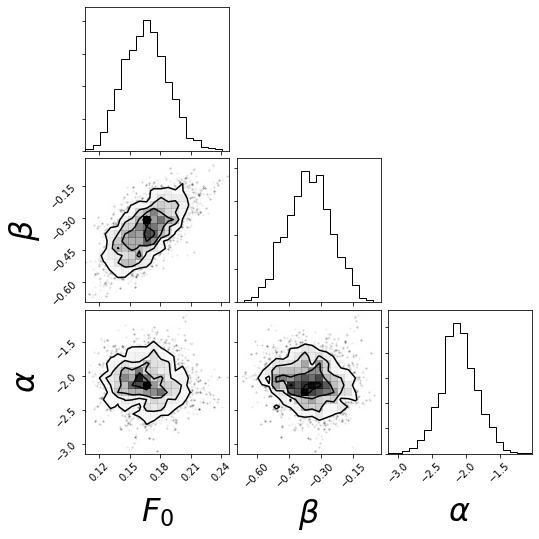

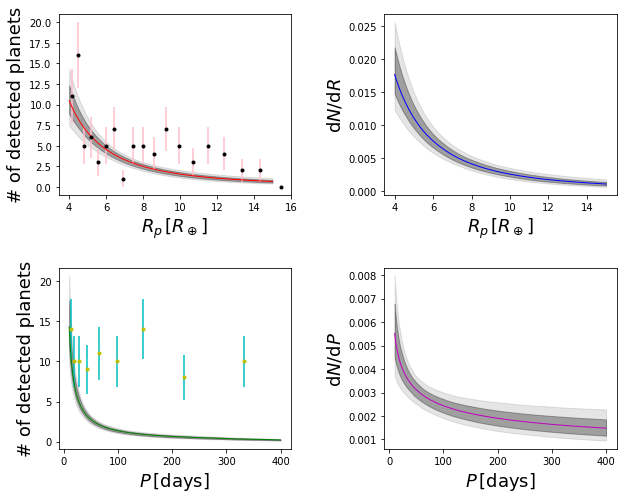

0.8487320876620026


In [43]:
##################################################################
##################################################################

corner.corner(samples_noreliability, labels=getModelLabels(model), label_kwargs = {"fontsize": 32})
#plt.savefig("occPostNoReliability.pdf",bbox_inches='tight')

##################################################################

gamma_earth_no_reliability, fig = plot_results(samples_noreliability)
#plt.savefig("occMargNoReliability.pdf",bbox_inches='tight')
#print(np.mean(gamma_earth_no_reliability))

##################################################################

Compute an occurrence rate with reliability

In [44]:
nTrials = 100

f = FloatProgress(min=0, max=nTrials)
display(f)

allKois = kois
for mCount in range(nTrials):
    # randomly select kois
    
    koiSelect = (np.random.rand(len(allKois)) < allKois.totalReliability)
#    koiSelect = (np.random.rand(len(allKois)) < allKois.reliability)
    kois = allKois[koiSelect]
#    kois.to_csv("occurenceRatePosteriors/selectedPcs" + str  (mCount) + ".csv")
#    print(str(mCount) + " of " + str(nTrials) + ", selected " + str(len(kois)) 
#          + " kois out of " + str(len(allKois)) + " after reliability cut")
    
    koi_periods = np.array(kois.koi_period)
    koi_rps = np.array(getRadii(kois))

    theta_0 = initRateModel(model)
    r = minimize(nll, theta_0, method="L-BFGS-B", bounds=bounds)

    ##################################################################


    ndim, nwalkers = len(r.x), 2*len(r.x)
    pos = [r.x + 1e-5 * np.random.randn(ndim) for i in range(nwalkers)]
    sampler = emcee.EnsembleSampler(nwalkers, ndim, lnprob)

    # Burn in.
    pos, _, _ = sampler.run_mcmc(pos, 200)
    sampler.reset()

    # Production.
    pos, _, _ = sampler.run_mcmc(pos, 1000)

    samples = sampler.flatchain   
    if mCount == 0:
        allSamples = samples[0:-1:10,:]
    else:
        allSamples = np.concatenate((allSamples, samples[0:-1:10,:]))
    
    f.value += 1

FloatProgress(value=0.0)

/Users/anne/anaconda2/envs/python3/lib/python3.6/site-packages/ipykernel_launcher.py:6: RuntimeWarning: invalid value encountered in log
  


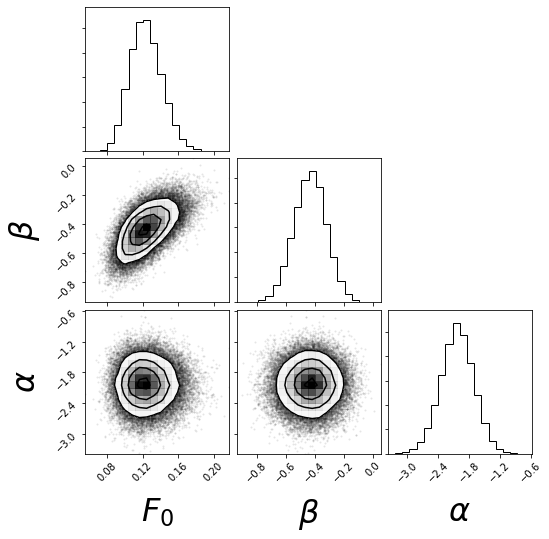

In [45]:
corner.corner(allSamples, labels=getModelLabels(model), label_kwargs = {"fontsize": 32});
#plt.savefig("occPostReliability.pdf",bbox_inches='tight')

In [46]:
modelLabels = getModelLabels(model)
for i in range(0,ndim):
    print("MCMC no reliability " + modelLabels[i] + "=" + printMedianAndErrorbars(samples_noreliability[:,i]))
for i in range(0,ndim):
    print("MCMC with reliability " + modelLabels[i] + "=" + printMedianAndErrorbars(allSamples[:,i]))

MCMC no reliability $F_0$=0.166^{+0.022}_{-0.022}
MCMC no reliability $\beta$=-0.356^{+0.104}_{-0.109}
MCMC no reliability $\alpha$=-2.108^{+0.272}_{-0.245}
MCMC with reliability $F_0$=0.123^{+0.019}_{-0.017}
MCMC with reliability $\beta$=-0.431^{+0.110}_{-0.115}
MCMC with reliability $\alpha$=-2.028^{+0.316}_{-0.319}


In [54]:
#gamma_earth, fig = plot_results(allSamples)
#plt.savefig("occMargReliability.png",bbox_inches='tight')

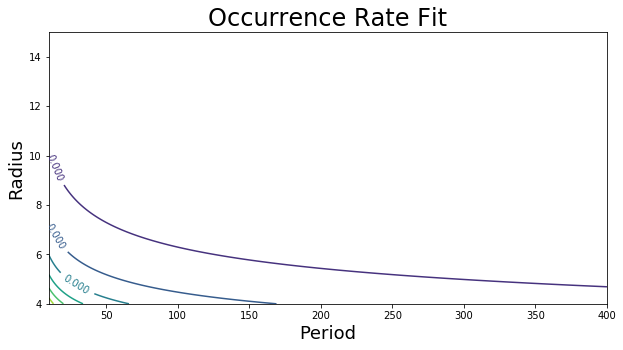

In [47]:
fig, ax = plt.subplots(figsize=(10,5))
rateGrid = rateModel(period_grid, rp_grid, period_rng, rp_rng, np.median(allSamples, 0), model)
CS = ax.contour(period_grid, rp_grid, rateGrid)
ax.clabel(CS, inline=1, fontsize=10)
#plt.yscale('log')
#plt.xscale('log')
#plt.ylim(0, 10)
#plt.xlim(0, 500)
plt.xlabel("Period", fontsize = 18)
plt.ylabel("Radius", fontsize = 18)
plt.title("Occurrence Rate Fit", fontsize = 24)
plt.show()

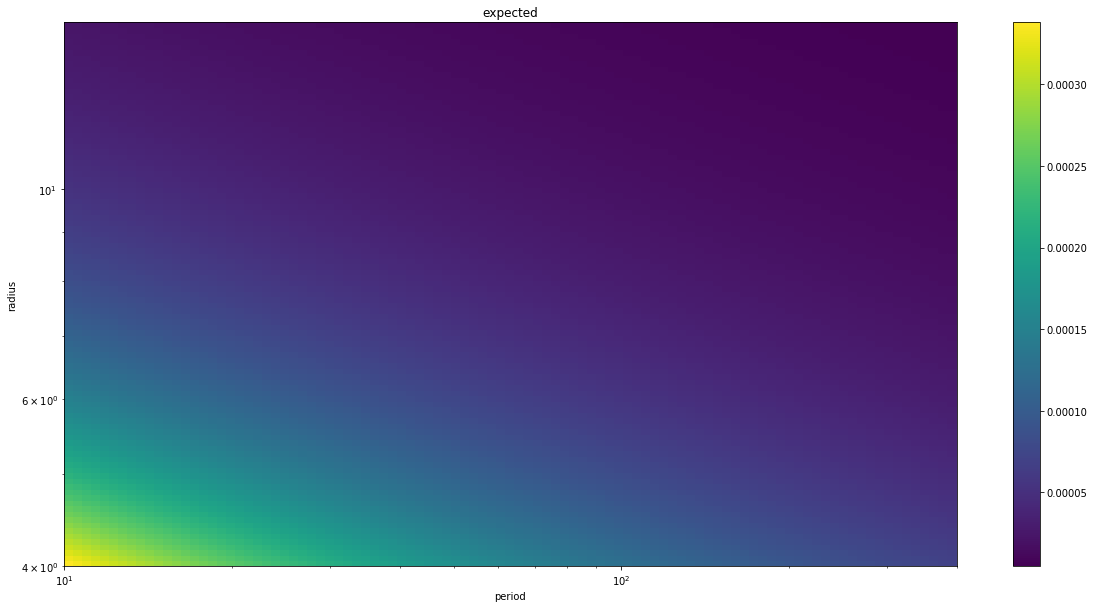

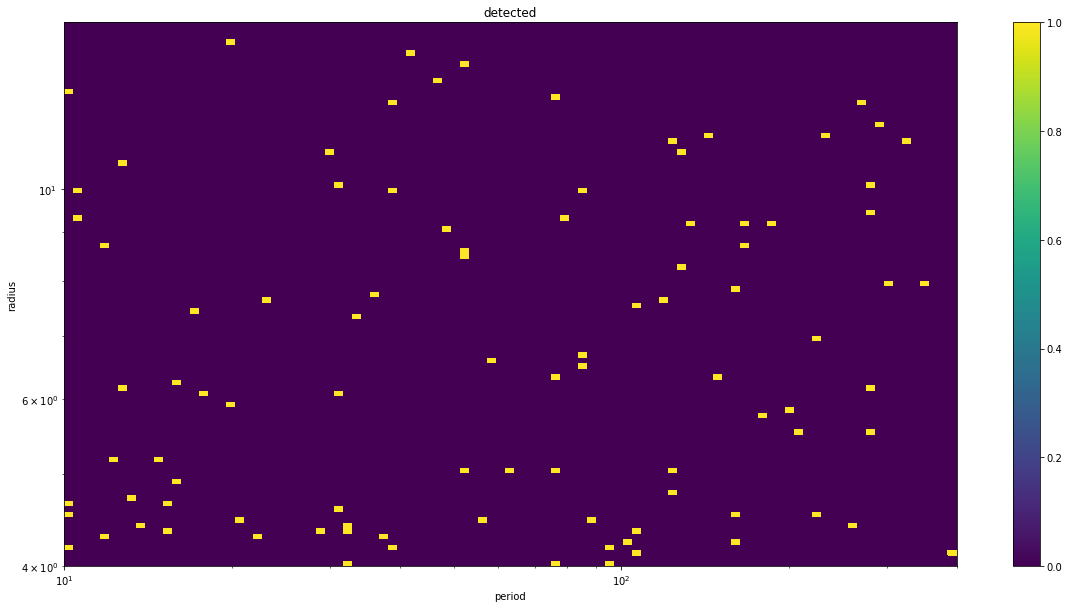

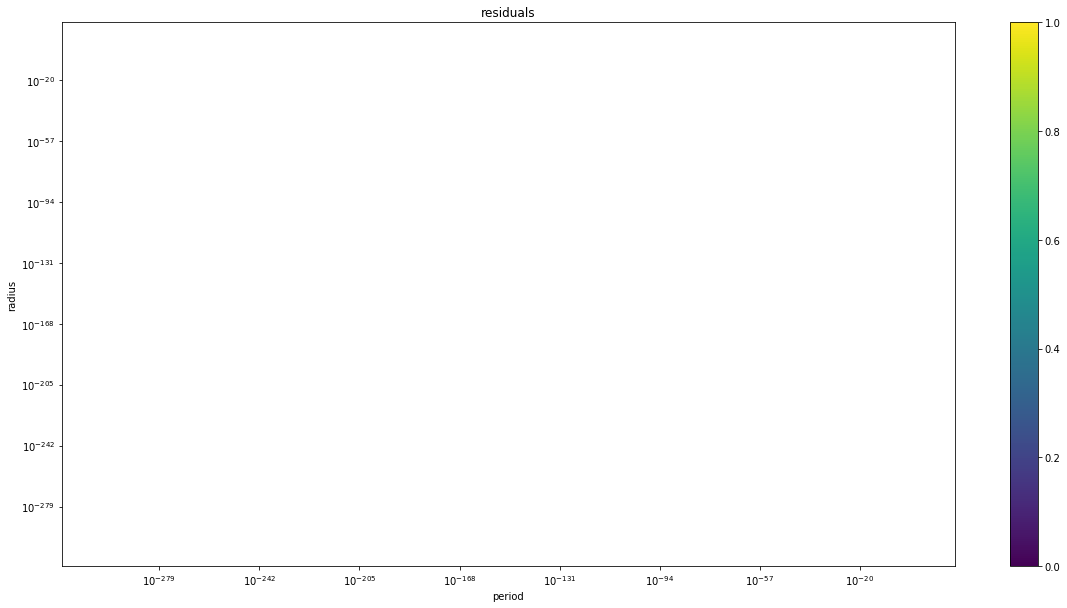

In [48]:
o = (rateModel(period_grid, rp_grid, period_rng, rp_rng, np.median(allSamples, 0), model))

fig, ax = plt.subplots(figsize=(20, 10))
#ax = fig.add_subplot(132)
im = ax.pcolormesh(period_grid, rp_grid, o)
#plt.xlim(.1,500)
plt.xscale('log')
plt.yscale('log')
plt.xlabel('period')
plt.ylabel('radius')
fig.colorbar(im)
plt.title("expected")

fig, ax = plt.subplots(figsize=(20, 10))
#ax = fig.add_subplot(132)
im = ax.pcolormesh(period_grid, rp_grid, H)
#plt.xlim(.1,500)
plt.xscale('log')
plt.yscale('log')
plt.xlabel('period')
plt.ylabel('radius')
fig.colorbar(im)
plt.title('detected')

fig, ax = plt.subplots(figsize=(20, 10))
#ax = fig.add_subplot(132)
#im = ax.pcolormesh(period_grid[:-1, :-1], rp_grid[:-1, :-1], H-o[:-1, :-1])
#plt.xlim(.1,500)
plt.xscale('log')
plt.yscale('log')
plt.xlabel('period')
plt.ylabel('radius')
fig.colorbar(im)
plt.title('residuals')
plt.show()

(100, 100)


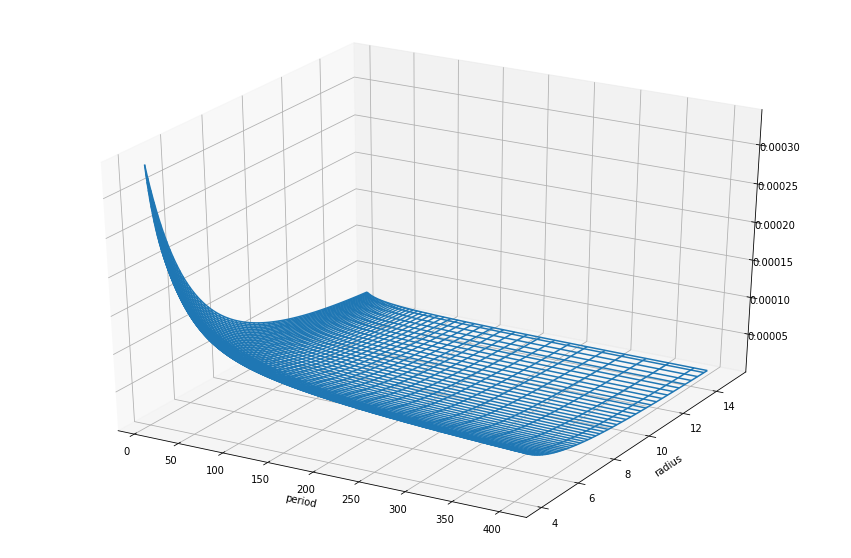

In [49]:
from mpl_toolkits.mplot3d import axes3d
fig = plt.figure(figsize=(15,10))
ax = fig.add_subplot(111, projection='3d')

print(rateGrid.shape)

#ax.plot_wireframe(period_grid, rp_grid, summedCompleteness / kiclist.size, rstride=2, cstride=2)
ax.plot_wireframe(period_grid, rp_grid, rateGrid)
ax.set_xlabel('period')
ax.set_ylabel('radius')
plt.show()

[[0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 ...
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 1. ... 0. 0. 0.]]


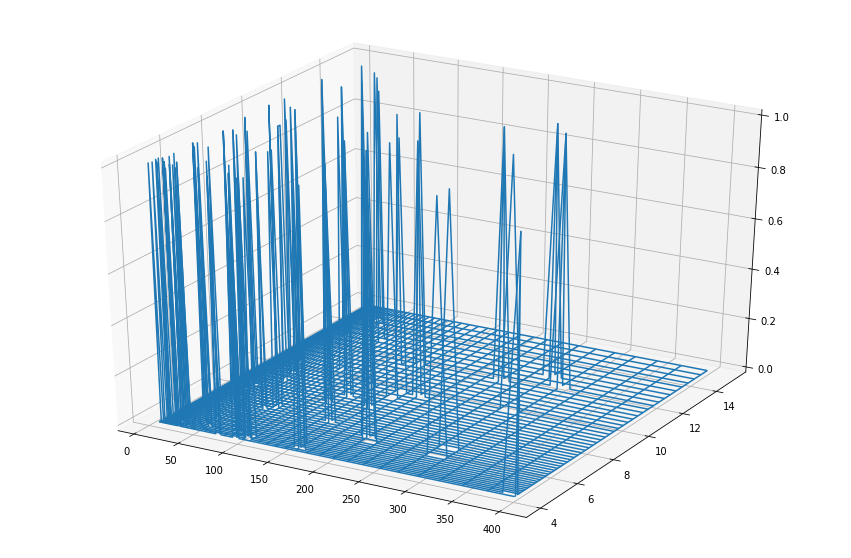

In [36]:
fig = plt.figure(figsize=(15,10))
ax = fig.add_subplot(111, projection='3d')

print(H)

#ax.plot_wireframe(period_grid, rp_grid, summedCompleteness / kiclist.size, rstride=2, cstride=2)
ax.plot_wireframe(period_grid[1:, 1:], rp_grid[1:, 1:], H)
plt.show()

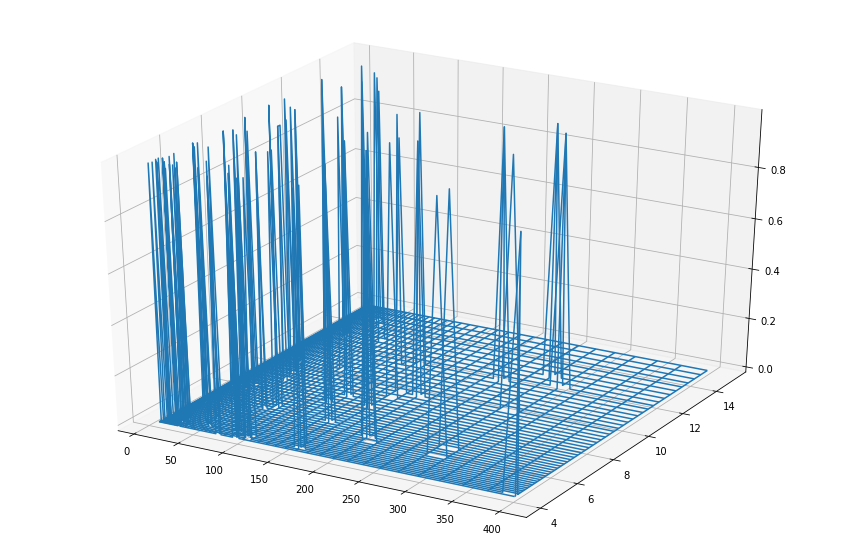

In [37]:
fig = plt.figure(figsize=(15,10))
ax = fig.add_subplot(111, projection='3d')

res = H - rateGrid[1:, 1:]

#ax.plot_wireframe(period_grid, rp_grid, summedCompleteness / kiclist.size, rstride=2, cstride=2)
ax.plot_wireframe(period_grid[1:, 1:], rp_grid[1:, 1:], res)
plt.show()

In [38]:
H, xedges, yedges = np.histogram2d(res, bins=(period, rp), density=True)

#X, Y = np.meshgrid(xedges, yedges)
fig, ax = plt.subplots(figsize=(20, 10))
#ax = fig.add_subplot(132)
im = ax.pcolormesh(period_grid, rp_grid, H)
#plt.xlim(.1,500)
fig.colorbar(im)
plt.xlabel('period')
plt.ylabel('radius')
plt.show()

TypeError: histogram2d() missing 1 required positional argument: 'y'

In [ ]:
print("F = " + printMedianAndErrorbars(samples_noreliability[:,0]))
print("radius exp (alpha) = " + printMedianAndErrorbars(samples_noreliability[:,2]))
print("period exp (beta) = " + printMedianAndErrorbars(samples_noreliability[:,1]))

In [ ]:
plt.hist(np.log10(gamma_earth_no_reliability), 50, histtype="step", color="k", density=True)
plt.gca().set_yticklabels([])
plt.title("the rate of Earth analogs: " + str(10**np.mean(np.log10(gamma_earth_no_reliability))))
plt.xlabel(r"$\log_{10}\Gamma_\oplus = \left. \log_{10}\mathrm{d}N / \mathrm{d}\ln P \, \mathrm{d}\ln R_p \right |_\oplus$");

print("Mean Gamma_Earth = {0}".format(10**np.mean(np.log10(gamma_earth_no_reliability))))
print("Gamma at p=365 days, r=1Re without reliability = " + printMedianAndErrorbars(gamma_earth_no_reliability))

In [ ]:
F1Dist_nr = integrateRateModel([50.,200.], [1., 2.], samples_noreliability, model)
print("1-2Re, 50-200 Days without reliability = " + printMedianAndErrorbars(F1Dist_nr))

F1Dist_nr = integrateRateModel([50.,300.], [0.75, 2.5], samples_noreliability, model)
print("0.75-2.5Re, 50-300 Days without reliability = " + printMedianAndErrorbars(F1Dist_nr))